# $GROUP$ $36$ $PROJECT$ $REPORT$
### $Predicting$ $Water$ $Levels$ $in$ $Venice$

**INTRODUCTION**

For our project, we are going to observe a dataset that describes water levels in Venice, Italy. Venice is known for its yearly flooding and is at risk of completely flooding in the future if water levels continue to rise. This dataset contains data from 1983 to 2015, and includes the water level in centimeters for every hour of every day. Our predictive question is:
### “What will the average water level in Venice be ten years from now?” 

Flooding in Venice is much more impactful and frequent than in other cities, as it is built on multiple small islands connected by bridges and water canals. Its location causes it to flood on a regular basis, but due to global warming and the nature of Venice’s geography, the floods have gotten more severe over the years. For example, on November 12 2019, residents of Venice went through the usual routine to prepare for a flood. The water level started to rise far above the predicted water level destroying homes, business, and historical landmarks, costing the city millions of dollars. A significant portion of Venice's economy is from tourism and trade through its ports. Any significant flood would drive tourists away and slow down port activity, impacting the economy of this city on top of flood damage repairs. The floods in Venice are becoming more destructive and unpredictable, costing the city more and more each year, which is why we need to predict the water levels far into the future, so that the city can prepare for even higher floods. 

We aim to observe possible trends in the average water level per year starting from 1983 and use regression to predict how much the water level will increase or decrease in the future. Since the dataset ends at the year 2015, we want to predict the average yearly water level ten years from that, in 2025.

**DATA ANALYSIS**


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We first loaded in our dataset and cleaned it by separating the `datetime` column into separate columns for year, month, and date. We used all the data from the original dataset, and did not need to remove any variables, as the dataset contains all the information we need already; the different water levels and the time at which they were recorded.

Next, we wrangled our data so that it contained the values we needed for our prediction. We filtered out the year 2016, as there was only 1 data point for it whereas the other years had thousands of data points. This prevents the data for 2016 from being an outlier. We then grouped our data by year and summarized it to take the mean of the water levels. This gives us an overall average water level for every year from 1983 to 2015. 

For spliting the data we chose a 80/20 split. We want to predict the yearly average for future years, therefore we split the data after wrangling so the testing and training data were both the same format (yearly average). We then visualized our data using a line plot with points.

In [2]:
set.seed(2000) 

#read in dataset from web
data<-read_csv('https://github.com/lbcommer/venezia-high-waters/raw/master/output/venezia.csv') |>
                                separate(col=datetime, into=c('Year', 'Month', 'Date'), sep='-', convert=TRUE) |>
                                separate(col=Date, into=c('Day', 'Time'), sep=" ", convert=TRUE)

set.seed(2000)
filtered_data <- data |>  
filter(Year != "2016") |> group_by(Year,Month) |> summarise(month_average = mean(level))
filtered_data

water_ts <- ts(filtered_data, start=c(1983, 1), end = c(2015, 12), frequency=12) 

time_series_df <- as.data.frame(water_ts)


Rows: 289272 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): level
dttm (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Year,Month,month_average
<int>,<int>,<dbl>
1983,1,7.30148
1983,2,19.67262
1983,3,16.70430
⋮,⋮,⋮
2015,10,41.88038
2015,11,32.03889
2015,12,15.00941


From inspection of the summary tibbles above, we can see that the `mean_yearly` column, which represents the average water level for each year, is increasing as the years go by. In 1983 the water level starts in the low 20s, but we can observe that by the later years, the water levels have increased well into the 30s.

Below is an initial plot of our training data. It shows the average water levels for every year in our dataset, from 1983 to 2015. from the plot, we can observe that the average water levels fluctuate quite frequently between different years. However, there is an overall increasing trend as the years go by, indicating that on a broad level, water levels in Venice are rising as time passes.

In [3]:
# concatenate the 2 columns for year & month and set the date to 01 for being able to use as.Date
time_series_df$year_month <- paste(time_series_df$Year,"-", time_series_df$Month, "-01", sep = "")
time_series_df$year_month <- as.Date(time_series_df$year_month)

time_series_df<-mutate(time_series_df, tibble(Month=seq(1,396))) |>
select(-Year)
time_series_df

# use initial_time_split instead of initial_split since it's time series - not independent of each other
data_split <- initial_time_split(time_series_df, prop = 0.7, strata = Year)
training_data <- training(data_split)
testing_data <- testing(data_split)

training_data
testing_data


Month,month_average,year_month
<int>,<dbl>,<date>
1,7.30148,1983-01-01
2,19.67262,1983-02-01
3,16.70430,1983-03-01
⋮,⋮,⋮
394,41.88038,2015-10-01
395,32.03889,2015-11-01
396,15.00941,2015-12-01


,Month,month_average,year_month
,<int>,<dbl>,<date>
1,1,7.30148,1983-01-01
2,2,19.67262,1983-02-01
3,3,16.70430,1983-03-01
⋮,⋮,⋮,⋮
275,275,32.57500,2005-11-01
276,276,31.99866,2005-12-01
277,277,16.47849,2006-01-01


,Month,month_average,year_month
,<int>,<dbl>,<date>
278,278,24.19643,2006-02-01
279,279,32.48656,2006-03-01
280,280,24.96806,2006-04-01
⋮,⋮,⋮,⋮
394,394,41.88038,2015-10-01
395,395,32.03889,2015-11-01
396,396,15.00941,2015-12-01


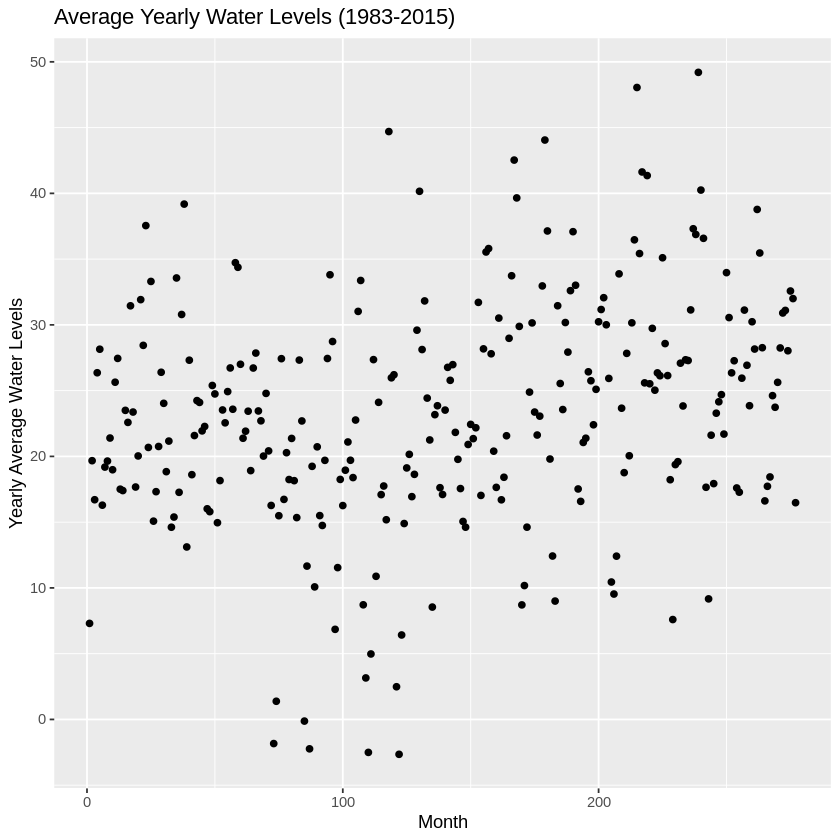

In [4]:
graph_data <- training_data|>
ggplot(aes(x = Month, y = month_average)) + geom_point()+
labs( x = "Month", y = "Yearly Average Water Levels", title = "Average Yearly Water Levels (1983-2015)")

graph_data


In [5]:
set.seed(2020)

lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")
data_recipe <- recipe(month_average ~ Month, data = training_data)


In [6]:
set.seed(2020)

data_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(lm_spec) |>
  fit(data = training_data)


In [7]:
lm_rmse <- data_fit |>
  predict(training_data) |>
  bind_cols(training_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
   select(.estimate) |>
   pull()

lm_rmse


[1] 8.466624

In [8]:
lm_rmspe <- data_fit |>
  predict(testing_data) |>
  bind_cols(testing_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
   select(.estimate) |>
   pull()

lm_rmspe


[1] 9.352888

`geom_smooth()` using formula 'y ~ x'



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)        Month  
    19.2681       0.0283  


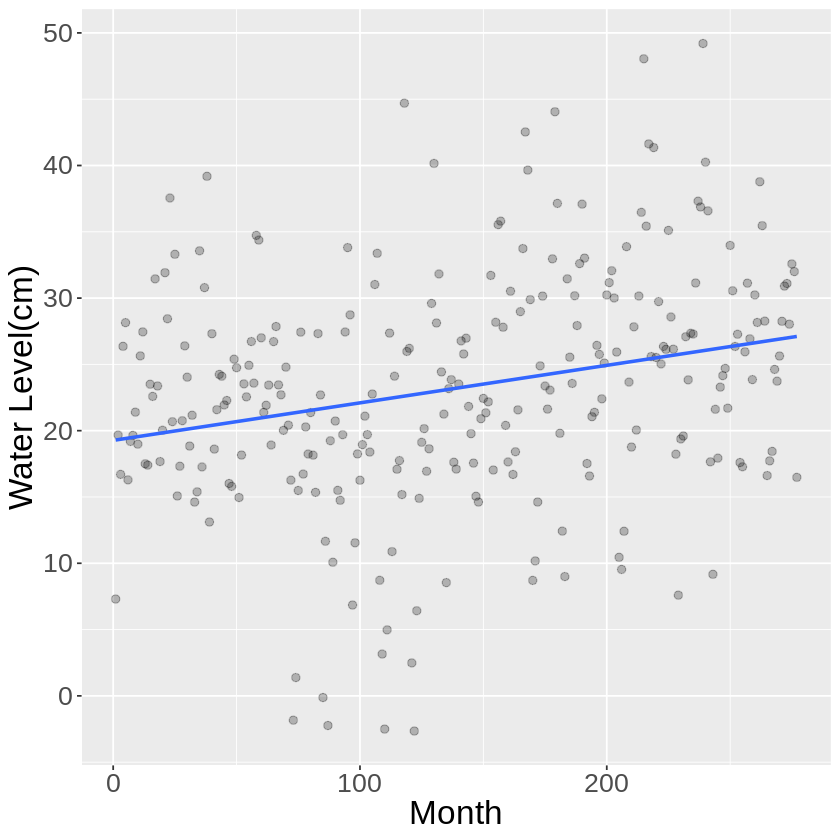

In [9]:
lm_predictions_test <- training_data |>
     ggplot(aes(x = Month, y = month_average)) +
         geom_point(alpha = 0.25, size=2) +
         geom_smooth(data=training_data, aes(x = Month, y = month_average),method = "lm", se = FALSE) +
         xlab("Month") +
         ylab("Water Level(cm)") +
         theme(text = element_text(size = 20))

lm_predictions_test

data_fit


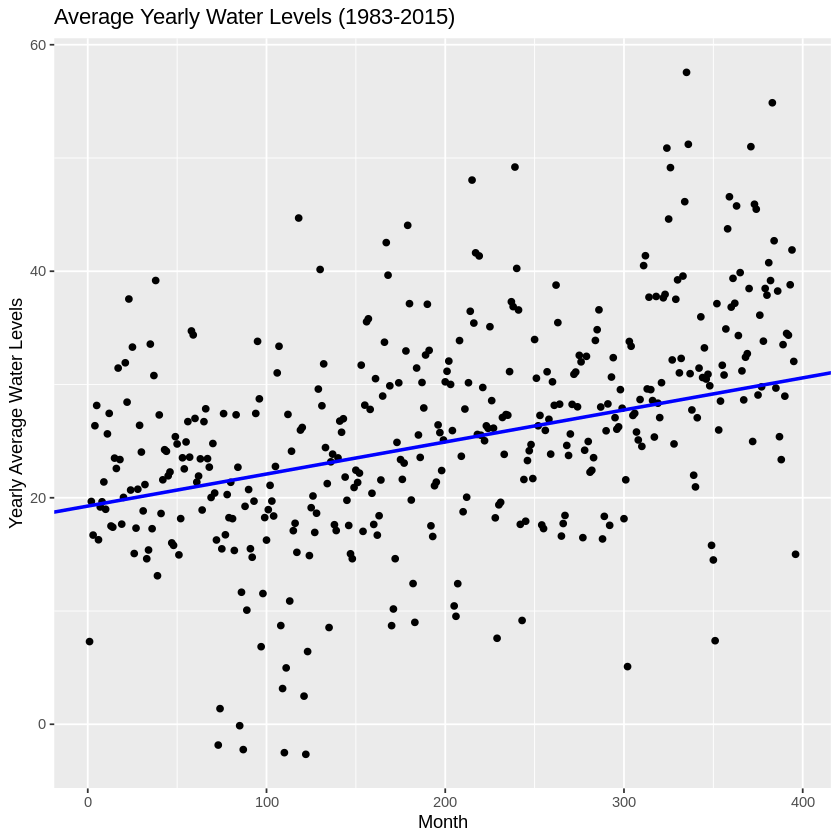

In [16]:
prediction_line<-ggplot(time_series_df, aes(x = Month, y = month_average)) + geom_point()+
labs( x = "Month", y = "Yearly Average Water Levels", title = "Average Yearly Water Levels (1983-2015)")+
geom_abline(intercept=19.2681, slope=0.0283, color='blue', lwd=1)

prediction_line

In [11]:
<-9.298e-0+1.488e+01
y

[1] 16.74425

**CITATIONS**

Kaggle link to original dataset: https://www.kaggle.com/datasets/lbronchal/venezia

Article about rising water levels in Venice posing danger of submersion for the city: https://thehill.com/changing-america/sustainability/climate-change/579490-an-expert-explains-how-rising-sea-levels-could/

Article about how climate change impacting water levels is affecting Venice's tourism economy: https://www.euronews.com/travel/2022/06/01/climate-change-and-cruise-ships-can-venice-survive-the-rising-tides

Article about destructive nature of floods in Venice, how people are affected: https://www.forbes.com/sites/rebeccahughes/2020/11/12/venice-1-year-on-from-devastating-flooding-no-more-acqua-alta/?sh=cc8eec14809f

Article about monetary cost and impact of flooding in Venice: https://www.businessinsider.com/flooding-cost-1-billion-of-damage-to-venice-tourist-attractions-2019-12